In [1]:
import xarray as xr # type: ignore
import cftime # type: ignore
import os
import pandas as pd # type: ignore

import matplotlib.pyplot as plt # type: ignore

from datetime import datetime
import seaborn as sns # type: ignore

In [2]:
file_path = "data2/*.nc4"
ds = xr.open_mfdataset(file_path, decode_times=False, combine='nested', concat_dim='time', chunks={})
output_filename = 'other_data.nc'
ds.to_netcdf(output_filename)

c:\Users\DELL\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [16]:
da = xr.open_dataset('data2/other_data.nc')
Kumasi = da.sel(lat=6.72,lon=-1.6, method='nearest')
Kumasi['Wind Speed'], Kumasi['Air Temperature'], Kumasi['Specific Humidity'] = Kumasi['Wind_f_inst'], Kumasi['Tair_f_inst'], Kumasi['Qair_f_inst']
annual_totals = Kumasi[['Wind Speed','Air Temperature','Specific Humidity']].groupby('time.year').mean('time')
monthly_totals = Kumasi[['Wind Speed','Air Temperature','Specific Humidity']].groupby('time.month').mean('time')

Kumasi

<xarray.Dataset>
Dimensions:            (time: 168, bnds: 2)
Coordinates:
  * time               (time) datetime64[ns] 2010-01-01 ... 2023-12-01
    lon                float32 -1.5
    lat                float32 6.5
Dimensions without coordinates: bnds
Data variables:
    time_bnds          (time, bnds) datetime64[ns] ...
    Wind_f_inst        (time) float32 ...
    Tair_f_inst        (time) float32 ...
    Qair_f_inst        (time) float32 ...
    Psurf_f_inst       (time) float32 ...
    Wind Speed         (time) float32 ...
    Air Temperature    (time) float32 ...
    Specific Humidity  (time) float32 ...
Attributes: (12/20)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    Conventions:            CF-1.6
    history:                created on date: 2019-09-27T23:01:53.919
    source:                 Noah_v3.6 forced with GDAS-AGRMET-GPCPv13rA1
    institution:            NASA GSFC
    missing_value:          -9999.0
    ...                     ...
    SOUTH_WEST_CORNER_LAT:  -59.5
    SOUTH_WEST_CORNER_LON:  -179.5
    DX:                     1.0
    DY:                     1.0
    history_L34RS:          'Created by L34RS v1.4.4 @ NASA GES DISC on May 2...
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

In [17]:
monthly_totals

<xarray.Dataset>
Dimensions:            (month: 12)
Coordinates:
    lon                float32 -1.5
    lat                float32 6.5
  * month              (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    Wind Speed         (month) float32 1.152 1.321 1.436 ... 1.099 1.099 1.061
    Air Temperature    (month) float32 300.2 301.2 301.0 ... 298.2 299.1 299.7
    Specific Humidity  (month) float32 0.01215 0.01465 ... 0.01649 0.01319
Attributes: (12/20)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    Conventions:            CF-1.6
    history:                created on date: 2019-09-27T23:01:53.919
    source:                 Noah_v3.6 forced with GDAS-AGRMET-GPCPv13rA1
    institution:            NASA GSFC
    missing_value:          -9999.0
    ...                     ...
    SOUTH_WEST_CORNER_LAT:  -59.5
    SOUTH_WEST_CORNER_LON:  -179.5
    DX:                     1.0
    DY:                     1.0
    history_L34RS:          'Created by L34RS v1.4.4 @ NASA GES DISC on May 2...
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

In [18]:
import numpy as np # type: ignore

def subset_periods(df, event_months, before_months, after_months):
    periods = []
    for i, event_year in enumerate(event_months):
        # Ensure that the period doesn't go beyond the bounds of the data
        before_start = max(event_year - before_months[i], df['month'].min())
        after_end = min(event_year + after_months[i], df['month'].max())
        period = df.sel(month=slice(before_start, after_end))
        periods.append(period)
    return periods

# Assuming you have identified high impact rainfall event years and defined before_years and after_years accordingly
event_months = [6, 10]
before_months = [5, 9]  # For example, 2 years before for 2022 event and 1 year before for 2023 event
after_months = [7, 2]   # For example, 1 year after for 2022 event and 2 years after for 2023 event
periods = subset_periods(monthly_totals, event_months, before_months, after_months)
periods

[<xarray.Dataset>
 Dimensions:            (month: 12)
 Coordinates:
     lon                float32 -1.5
     lat                float32 6.5
   * month              (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
 Data variables:
     Wind Speed         (month) float32 1.152 1.321 1.436 ... 1.099 1.099 1.061
     Air Temperature    (month) float32 300.2 301.2 301.0 ... 298.2 299.1 299.7
     Specific Humidity  (month) float32 0.01215 0.01465 ... 0.01649 0.01319
 Attributes: (12/20)
     CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
     Conventions:            CF-1.6
     history:                created on date: 2019-09-27T23:01:53.919
     source:                 Noah_v3.6 forced with GDAS-AGRMET-GPCPv13rA1
     institution:            NASA GSFC
     missing_value:          -9999.0
     ...                     ...
     SOUTH_WEST_CORNER_LAT:  -59.5
     SOUTH_WEST_CORNER_LON:  -179.5
     DX:                     1.0
     DY:                     1.0
     history

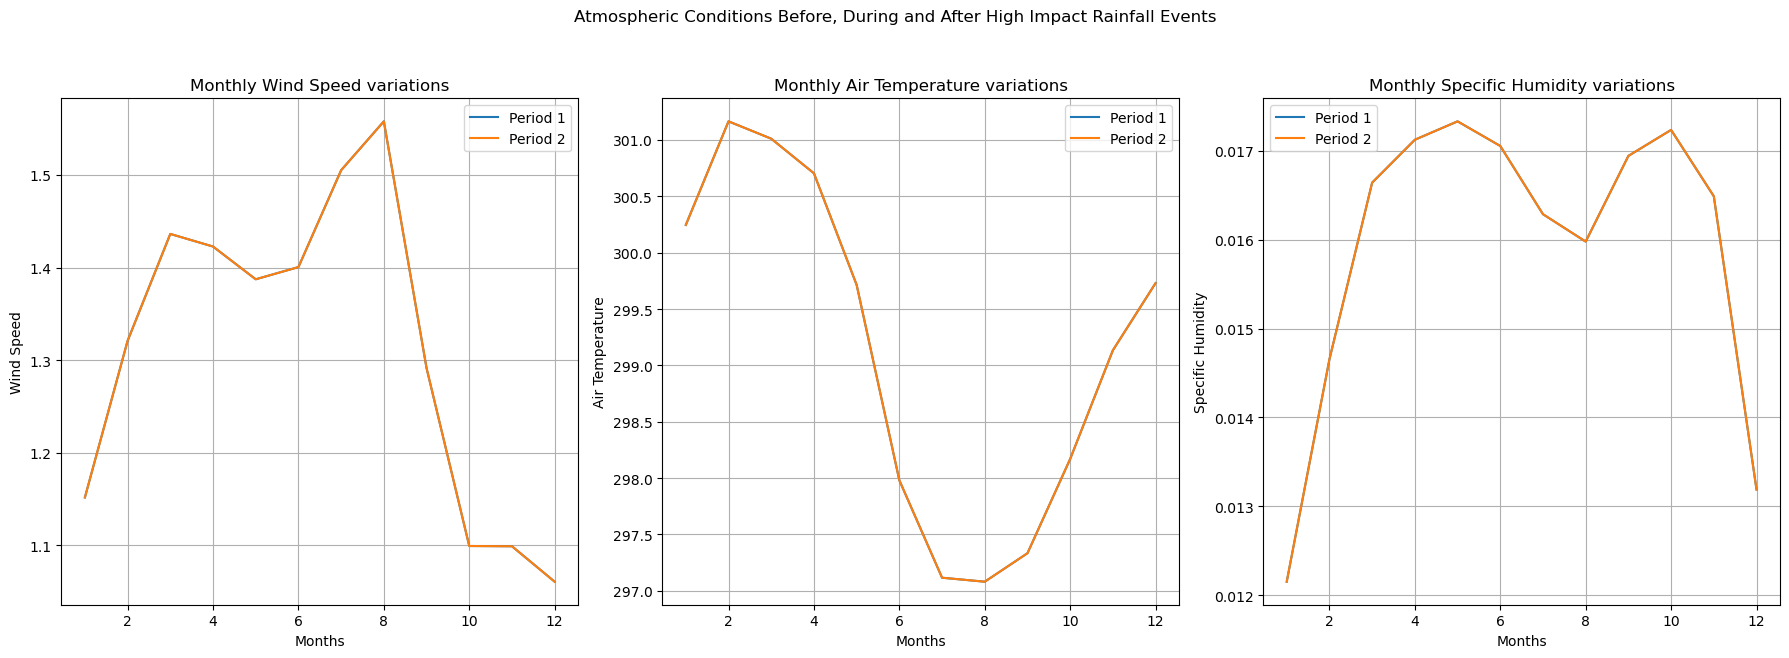

In [19]:
summary_stats = []
for period in periods:
    summary_stats.append(period)

# Step 3: Visualization
# Create time series plots for each variable
variables = ['Wind Speed','Air Temperature','Specific Humidity']
fig, axs = plt.subplots(1, len(variables), figsize=(6 * len(variables), 6))

for i, variable in enumerate(variables):
    axs[i].set_title(f'Monthly {variable} variations')
    axs[i].set_xlabel('Months')
    axs[i].set_ylabel(variable)
    for j, period in enumerate(periods):
        axs[i].plot(period['month'], period[variable], label=f'Period {j+1}')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.suptitle("Atmospheric Conditions Before, During and After High Impact Rainfall Events", y=1.09)
plt.show()

In [21]:
import numpy as np # type: ignore

def subset_periods(df, event_years, before_years, after_years):
    periods = []
    for i, event_year in enumerate(event_years):
        # Ensure that the period doesn't go beyond the bounds of the data
        before_start = max(event_year - before_years[i], df['year'].min())
        after_end = min(event_year + after_years[i], df['year'].max())
        period = df.sel(year=slice(before_start, after_end))
        periods.append(period)
    return periods

# Assuming you have identified high impact rainfall event years and defined before_years and after_years accordingly
event_years = [2022, 2023]
before_years = [12, 13]  # For example, 2 years before for 2022 event and 1 year before for 2023 event
after_years = [1, 1]   # For example, 1 year after for 2022 event and 2 years after for 2023 event
periods = subset_periods(annual_totals, event_years, before_years, after_years)
periods


[<xarray.Dataset>
 Dimensions:            (year: 14)
 Coordinates:
     lon                float32 -1.5
     lat                float32 6.5
   * year               (year) int64 2010 2011 2012 2013 ... 2020 2021 2022 2023
 Data variables:
     Wind Speed         (year) float32 1.393 1.353 1.374 ... 1.237 1.211 1.209
     Air Temperature    (year) float32 299.1 299.1 299.1 ... 299.1 298.7 299.0
     Specific Humidity  (year) float32 0.01689 0.01609 ... 0.01501 0.01565
 Attributes: (12/20)
     CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
     Conventions:            CF-1.6
     history:                created on date: 2019-09-27T23:01:53.919
     source:                 Noah_v3.6 forced with GDAS-AGRMET-GPCPv13rA1
     institution:            NASA GSFC
     missing_value:          -9999.0
     ...                     ...
     SOUTH_WEST_CORNER_LAT:  -59.5
     SOUTH_WEST_CORNER_LON:  -179.5
     DX:                     1.0
     DY:                     1.0


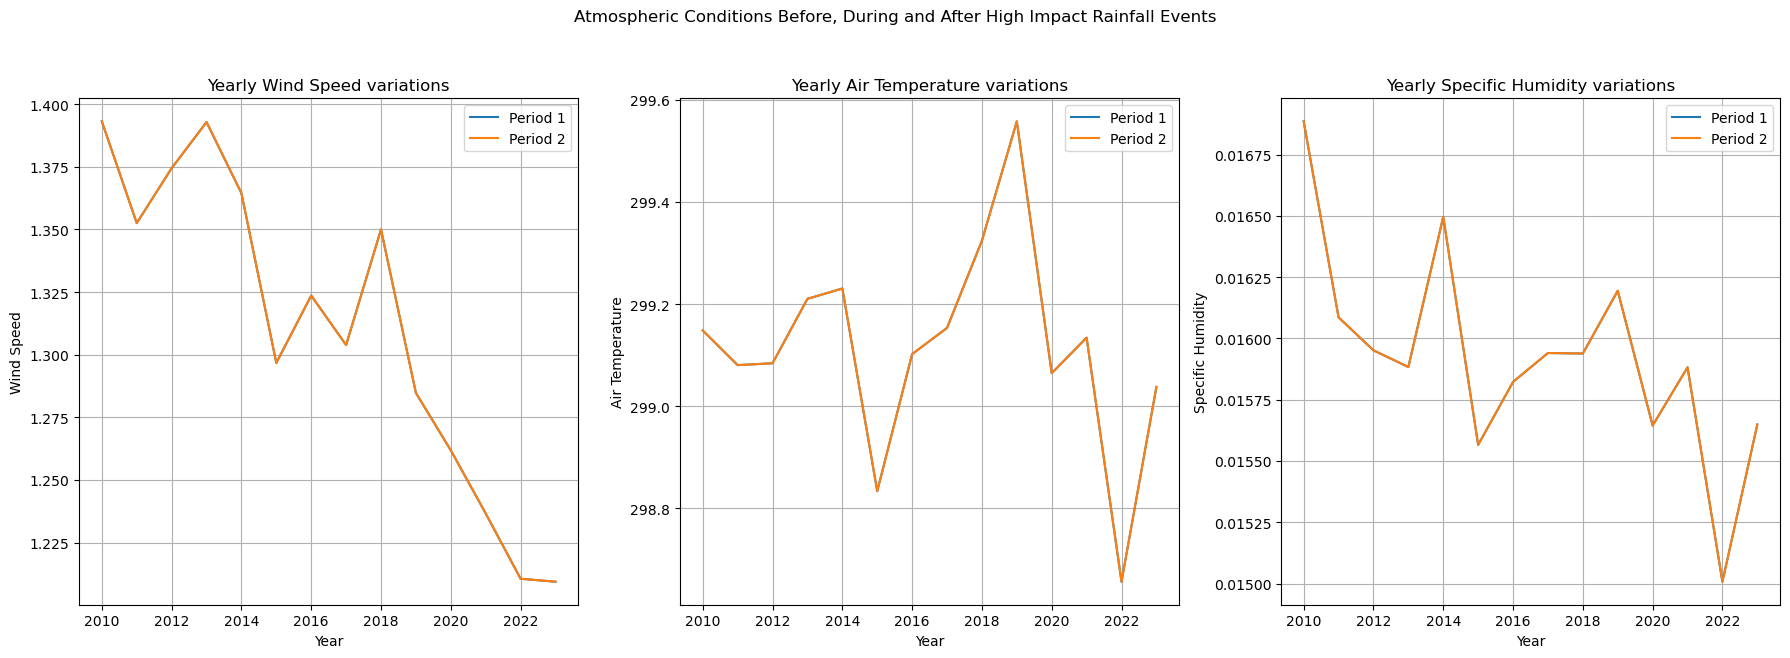

In [22]:
summary_stats = []
for period in periods:
    summary_stats.append(period)

# Step 3: Visualization
# Create time series plots for each variable
variables = ['Wind Speed','Air Temperature','Specific Humidity']
fig, axs = plt.subplots(1, len(variables), figsize=(6 * len(variables), 6))

for i, variable in enumerate(variables):
    axs[i].set_title(f'Yearly {variable} variations')
    axs[i].set_xlabel('Year')
    axs[i].set_ylabel(variable)
    for j, period in enumerate(periods):
        axs[i].plot(period['year'], period[variable], label=f'Period {j+1}')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.suptitle("Atmospheric Conditions Before, During and After High Impact Rainfall Events", y=1.09)
plt.show()